# Exploratory study on existing early warning systems

## * Setup of the working environment *

### Import traditional Python packages

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from datetime import datetime as dt, timedelta, date
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import pickle
import time
import math
import json
import sys
import os

In [2]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Import custom Python modules

In [4]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from helpers.db_connector import MySQLConnector
from helpers.db_query import *

from helpers.data_process import *
from helpers.feature_extraction import *

from extractors.akpinar_et_al import AkpinarEtAl
from extractors.boroujeni_et_al import BoroujeniEtAl
from extractors.chen_cui import ChenCui
from extractors.he_et_al import HeEtAl
from extractors.lalle_conati import LalleConati
from extractors.lemay_doleck import LemayDoleck
from extractors.mbouzao_et_al import MbouzaoEtAl
from extractors.mubarak_et_al import MubarakEtAl
from extractors.wan_et_al import WanEtAl

from helpers.ml_utils import *

from helpers.time import *

## * Load the clickstream data *

Since Fall 2017, the stream of the EPFL's Linear Algebra course has been taught in a flipped format. The implementation of the flipped classroom was carried out in an incremental manner, as described below:

- **Year 2017-2018**: traditional manner (weeks 1-13) - flipped manner (week 14).
- **Year 2018-2019**: traditional manner (weeks 1-4, 10-14) - flipped manner (weeks 5-9).
- **Year 2019-2020**: traditional manner (weeks 1-4) - flipped manner (weeks 5-14).

In [7]:
rounds = ['Y2-2018-19', 'Y3-2019-20']

### Identifying Students


The flipped course was offered only to volunteering students. The volunteers were collectively assigned into either the experimental and the control group. A stratified random sampling based on gender and the prior background (secondary educational level) of students were used.

In [8]:
%time user_data = getUserInfo(prior_knowledge=True)

Wall time: 1min 5s


The initial data of volunteers was cleaned, and some participants were removed before we analyzed the data:
- The volunteering students who have not been graded were removed. 
- The repeating students were filtered out, where repeating students are those accessing videos in two different years. 
- The less active students, i.e., those who have provided less 60 interactions in the platform, were removed. 

Given that the Y1-2017-2018 round included only one week in a flipped classroom setting, we will remove the students of that round.  

In [9]:
user_data = user_data[user_data['Round'].isin(rounds)]

Some of the statistics on the user data are provided below. 

In [10]:
"Number of students:", len(user_data)

('Number of students:', 214)

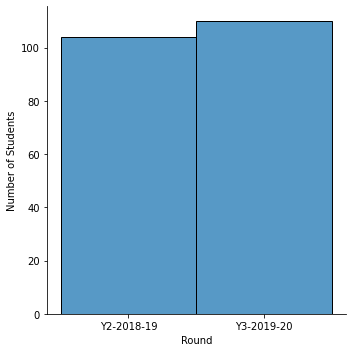

In [11]:
sns.displot(user_data, x='Round')
plt.ylabel('Number of Students')
plt.show()

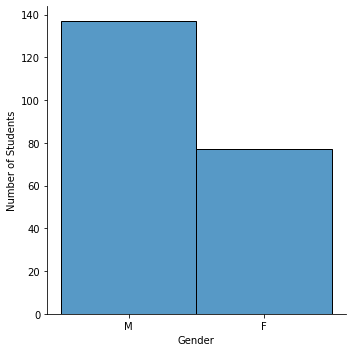

In [12]:
sns.displot(user_data, x='Gender')
plt.ylabel('Number of Students')
plt.show()

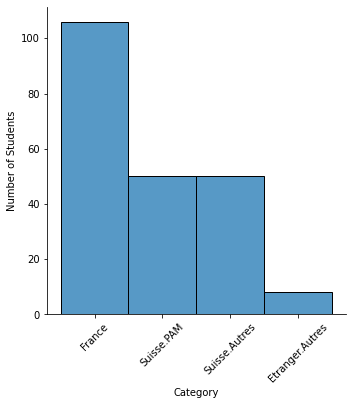

In [13]:
sns.displot(user_data, x='Category')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.show()

### Getting Students' Records

#### Video Clickstream Records

In [14]:
%time video_data = getVideoEventsInfo(mode='all')

Wall time: 1min 46s


In [15]:
video_data = video_data[video_data['Round'].isin(rounds)]

In [16]:
"Number of video events:", len(video_data)

('Number of video events:', 1416106)

#### Problem Clickstream Records

In [17]:
%time problem_data = getProblemEventsInfo()

Wall time: 1min 15s


In [18]:
problem_data = problem_data[problem_data['Round'].isin(rounds)]

In [19]:
"Number of problem events:", len(problem_data)

('Number of problem events:', 473924)

#### Exam Records

In [20]:
%time exam_data = getExamInfo()

Wall time: 1min 18s


In [21]:
exam_data = exam_data[exam_data['Round'].isin(rounds)]

In [22]:
exam_data = exam_data[exam_data['AccountUserID'].isin(user_data['AccountUserID'])]

In [23]:
"Number of graded students:", len(exam_data)

('Number of graded students:', 214)

#### Event Records

In [24]:
events = video_data.append(problem_data)

In [25]:
events['Year'] = events['Round'].apply(lambda x: int(x.split('-')[1]))

#### Course Week Column

We get the configuration file (e.g, start and end date) for each round of the course. 

In [26]:
with open('../config/linear_algebra.json') as f:
    config = json.load(f)

We assign each video interaction to a specific week of the course, with the first week of the course round having id 0. 

In [27]:
events['Date'] = events['TimeStamp'].apply(lambda x:string2Datetime(dt.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')))

In [28]:
tmp_events = []
for r in rounds:
    round_events = events[events['Round'] == r]
    tmp_events.append(processWeek(round_events, 'Date', config[r.split('-')[-2]]['Start']))
events = pd.concat(tmp_events).copy()

In [29]:
events['Week'] = events['Week'].apply(lambda x: int(x))

Then, we filter only the first *noCourseWeeks* course weeks. 

In [30]:
events = events[events['Week'].isin(range(20))]

## * Split data in training and test sets *

In [31]:
mode = 'random'
task = 'binary'
ratio = 80
start, end, step = 2, 16, 2

In [32]:
weeks = np.arange(start, end, step)

In [33]:
x_train, x_test, y_train, y_test = getTrainTestData(exam_data, mode, task, ratio / 100.0)

Binarizing student grades
> [(0, 80), (1, 134)]
Spitting the whole student population randomly
> Train 171 [(0, 64), (1, 107)]
> Test 43 [(0, 16), (1, 27)]


## * Extract and scale features from clickstreams *

In [34]:
feature_labels = [
    BoroujeniEtAl(),
    ChenCui(),
    HeEtAl(),
    LalleConati(),
    LemayDoleck(),
    MbouzaoEtAl(),
    MubarakEtAl(),
    WanEtAl(),
]

First, we check whether the required feature sets have been already pre-computed. 

In [47]:
filename = '../data/feature_sets/feature_sets_' + mode + '_' + task + '_' + str(ratio) + '_' + str(start) + '-' + str(end) + '-' + str(step) + '.pkl'

if os.path.exists(filename):
    print('Found features for this experimental setting in', filename)
    with open(filename, 'rb') as f:
        feature_sets = pickle.load(f)
else:
    feature_sets = {}

Then, for each feature set not pre-computed, the following snippet populates the corredponsing dictionary keys accordingly. 

In [48]:
for ffunc in feature_labels:
    flabel = ffunc.getName()
    
    if not flabel in feature_sets:
        feature_sets[flabel] = {}
        
        for wid in weeks:
            feature_sets[flabel][wid] = {}
            feature_sets[flabel][wid]['train'] = []
            feature_sets[flabel][wid]['test'] = []
            scaler = StandardScaler()
            
            unactiveTrain = 0
            for uindex, uid in enumerate(x_train): 
                print('\r', 'Set:', flabel, '- Week:', wid, '- Mode: train', '- User:', uindex + 1, len(x_train), end=' ')
                udata = events[(events['AccountUserID'] == uid) & (events['Week'] < wid)]
                if len(udata) > 0:
                    feature_sets[flabel][wid]['train'].append(ffunc.getUserFeatures(udata))
                else:
                    unactiveTrain += 1
                    feature_sets[flabel][wid]['train'].append([0 for i in range(ffunc.getNbFeatures())])
            feature_sets[flabel][wid]['train'] = scaler.fit_transform(np.array(feature_sets[flabel][wid]['train']))

            print('- Unactive:', unactiveTrain, '- Active:', len(x_train) - unactiveTrain)
            
            unactiveTest = 0
            for uindex, uid in enumerate(x_test): 
                print('\r', 'Set:', flabel, '- Week:', wid, '- Mode: test', '- User:', uindex + 1, len(x_test), end=' ')
                udata = events[(events['AccountUserID'] == uid) & (events['Week'] < wid)]
                if len(udata) > 0:
                    feature_sets[flabel][wid]['test'].append(ffunc.getUserFeatures(udata))
                else:
                    unactiveTest += 1
                    feature_sets[flabel][wid]['test'].append([0 for i in range(ffunc.getNbFeatures())])
            feature_sets[flabel][wid]['test'] = scaler.transform(np.array(feature_sets[flabel][wid]['test']))
            
            print('- Unactive:', unactiveTest, '- Active:', len(x_test) - unactiveTest)

 Set: boroujeni_et_al - Week: 2 - Mode: train - User: 171 171 - Unactive: 18 - Active: 153
 Set: boroujeni_et_al - Week: 2 - Mode: test - User: 43 43 - Unactive: 10 - Active: 33
 Set: boroujeni_et_al - Week: 4 - Mode: train - User: 171 171 - Unactive: 8 - Active: 163
 Set: boroujeni_et_al - Week: 4 - Mode: test - User: 43 43 - Unactive: 4 - Active: 39
 Set: boroujeni_et_al - Week: 6 - Mode: train - User: 171 171 - Unactive: 0 - Active: 171
 Set: boroujeni_et_al - Week: 6 - Mode: test - User: 43 43 - Unactive: 0 - Active: 43
 Set: boroujeni_et_al - Week: 8 - Mode: train - User: 171 171 - Unactive: 0 - Active: 171
 Set: boroujeni_et_al - Week: 8 - Mode: test - User: 43 43 - Unactive: 0 - Active: 43
 Set: boroujeni_et_al - Week: 10 - Mode: train - User: 171 171 - Unactive: 0 - Active: 171
 Set: boroujeni_et_al - Week: 10 - Mode: test - User: 43 43 - Unactive: 0 - Active: 43
 Set: boroujeni_et_al - Week: 12 - Mode: train - User: 171 171 - Unactive: 0 - Active: 171
 Set: boroujeni_et_al - W

For convenience, we save the feature sets computed for the current experimental setting.

In [49]:
if not os.path.exists(os.path.dirname(filename)):
    os.makedirs(os.path.dirname(filename))

with open(filename, 'wb') as f:
    pickle.dump(feature_sets, f, protocol=pickle.HIGHEST_PROTOCOL)

## * Define and train the predictive models *

For the prediction stage, we consider traditional shallow learning models optimized via grid search.

In [50]:
classifiers_types = {
    'ada': AdaBoostClassifier(),
    'dt': DecisionTreeClassifier(),
    'gnb': GaussianNB(),
    'lr': LogisticRegression(),
    'mlp': MLPClassifier(),
    'knn': KNeighborsClassifier(),
    'rf': RandomForestClassifier(),
    'svm': SVC()
}

In [51]:
classifiers_params = {
    'ada': {'n_estimators': [25, 50, 100, 200], 'algorithm': ('SAMME', 'SAMME.R'), 'learning_rate': [0.1, 1]},
    'dt': {'criterion': ('gini', 'entropy'), 'splitter': ('best', 'random'), 'max_features': ('auto', 'sqrt', 'log2')},
    'gnb': {'var_smoothing': [1e-9, 1e-7, 1e-5, 1e-3, 1e-1]},
    'lr': {'penalty': ('l1', 'l2', 'elasticnet', 'none'), 'tol': [1e-4, 1e-5], 'C': [1.0, 0.5], 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'), 'multi_class': ('auto', 'ovr', 'multinomial')},
    'mlp': {'activation': ('identity', 'logistic', 'tanh', 'relu'), 'solver': ('lbfgs', 'sgd', 'adam'), 'hidden_layer_sizes': [(8,), (16, 8), (32, 16, 8)]},
    'knn': {'n_neighbors': [5, 10, 50, 100], 'weights': ('uniform', 'distance'), 'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')},
    'rf': {'n_estimators': [25, 50, 100, 200], 'criterion': ('gini', 'entropy'), 'max_features': ('auto', 'sqrt', 'log2')},
    'svm': {'C': [1.0, 0.5], 'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'gamma': ('scale', 'auto'), 'shrinking': (True, False)}
}

For convenience, we load the trained models, in case they have been already computed under the same experimental setting. 

In [52]:
filename = '../data/trained_models/trained_models_' + mode + '_' + task + '_' + str(ratio) + '_' + str(start) + '-' + str(end) + '-' + str(step) + '.pkl'

if os.path.exists(filename):
    print('Found trained_models for this experimental setting in', filename)
    with open(filename, 'rb') as f:
        trained_models = pickle.load(f)
else:
    trained_models = {}

Once the prediction stage is well set, we run the training procedure for each of the considered models. 

In [53]:
for ffunc in feature_labels:
    flabel = ffunc.getName()
    
    if not flabel in trained_models:
        trained_models[flabel] = {}
        
        for wid in weeks:
            trained_models[flabel][wid] = {}
            print('Model:', flabel, '- Week:', wid, '- Algorithms:', end=' ')
            
            for mid in classifiers_types.keys(): 
                print(mid, end=' ')
                trained_models[flabel][wid][mid] = GridSearchCV(classifiers_types[mid], classifiers_params[mid])
                trained_models[flabel][wid][mid].fit(feature_sets[flabel][wid]['train'], y_train)
            
            print()

Model: boroujeni_et_al - Week: 2 - Algorithms: ada dt gnb lr mlp knn rf svm 
Model: boroujeni_et_al - Week: 4 - Algorithms: ada dt gnb lr mlp knn rf svm 
Model: boroujeni_et_al - Week: 6 - Algorithms: ada dt gnb lr mlp knn rf svm 
Model: boroujeni_et_al - Week: 8 - Algorithms: ada dt gnb lr mlp knn rf svm 
Model: boroujeni_et_al - Week: 10 - Algorithms: ada dt gnb lr mlp knn rf svm 
Model: boroujeni_et_al - Week: 12 - Algorithms: ada dt gnb lr mlp knn rf svm 
Model: boroujeni_et_al - Week: 14 - Algorithms: ada dt gnb lr mlp knn rf svm 
Model: lalle_conati - Week: 2 - Algorithms: ada dt gnb lr mlp knn rf svm 
Model: lalle_conati - Week: 4 - Algorithms: ada dt gnb lr mlp knn rf svm 
Model: lalle_conati - Week: 6 - Algorithms: ada dt gnb lr mlp knn rf svm 
Model: lalle_conati - Week: 8 - Algorithms: ada dt gnb lr mlp knn rf svm 
Model: lalle_conati - Week: 10 - Algorithms: ada dt gnb lr mlp knn rf svm 
Model: lalle_conati - Week: 12 - Algorithms: ada dt gnb lr mlp knn rf svm 
Model: lalle

We list the parameters selected by the grid search procedure, investigating whether they remain stable across weeks. 

In [54]:
for ffunc in feature_labels:
    flabel = ffunc.getName()
    print('Feature set:', flabel)
    for wid in weeks:
        print('> Week:', wid)
        for mid in classifiers_types.keys():
            print('>> Model:', mid, '-', trained_models[flabel][wid][mid].best_params_)

Feature set: boroujeni_et_al
> Week: 2
>> Model: ada - {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 200}
>> Model: dt - {'criterion': 'gini', 'max_features': 'log2', 'splitter': 'best'}
>> Model: gnb - {'var_smoothing': 1e-09}
>> Model: lr - {'C': 0.5, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'saga', 'tol': 1e-05}
>> Model: mlp - {'activation': 'relu', 'hidden_layer_sizes': (8,), 'solver': 'sgd'}
>> Model: knn - {'algorithm': 'auto', 'n_neighbors': 50, 'weights': 'uniform'}
>> Model: rf - {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 25}
>> Model: svm - {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True}
> Week: 4
>> Model: ada - {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 25}
>> Model: dt - {'criterion': 'entropy', 'max_features': 'auto', 'splitter': 'best'}
>> Model: gnb - {'var_smoothing': 1e-09}
>> Model: lr - {'C': 0.5, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'saga', 'tol': 0.0001}
>> Model: mlp - {'

For convenience, we save the trained models computed for the current experimental setting.

In [55]:
if not os.path.exists(os.path.dirname(filename)):
    os.makedirs(os.path.dirname(filename))

with open(filename, 'wb') as f:
    pickle.dump(trained_models, f, protocol=pickle.HIGHEST_PROTOCOL)

## * Define and compute the evaluation metrics *

In [56]:
def tn(y_true, y_pred):
    return confusion_matrix(y_true, y_pred).ravel()[0]

def fp(y_true, y_pred):
    return confusion_matrix(y_true, y_pred).ravel()[1]

def fn(y_true, y_pred):
    return confusion_matrix(y_true, y_pred).ravel()[2]

def tp(y_true, y_pred):
    return confusion_matrix(y_true, y_pred).ravel()[3]

def tpr(y_true, y_pred): 
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def tnr(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def fpr(y_true, y_pred): 
    return fp(y_true, y_pred) / (fp(y_true, y_pred) + tn(y_true, y_pred))

def fnr(y_true, y_pred): 
    return fn(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def eer(y_true, y_pred):
    return np.mean([fnr(y_true, y_pred), fpr(y_true, y_pred)])

Traditional metrics of effectiveness are considered for the prediction stage. Given that early warning systems should take particular care of the false negatives instances, the False Positive Rate will represent an essential measure of effectiveness.   

In [57]:
evaluation_metrics = {
    'Acc': accuracy_score,
    'F1': f1_score,
    'P': precision_score, 
    'R': recall_score,
    'TP': tp,
    'FN': fn,
    'TN': tn,
    'FP': fp,
    'TPR': tpr,
    'TNR': tnr,
    'FPR': fpr, 
    'FNR': fnr,
    'EER': eer
}

In [58]:
results = {}
for ffunc in feature_labels:
    flabel = ffunc.getName()
    results[flabel] = {}
    for wid in weeks:
        print(flabel, wid, end='\t')
        results[flabel][wid] = {}
        for mid in classifiers_types.keys(): 
            print(mid, end=' ')
            results[flabel][wid][mid] = {}
            clf = trained_models[flabel][wid][mid]
            for emid, mfunc in evaluation_metrics.items():
                results[flabel][wid][mid][emid] = mfunc(y_test, clf.predict(feature_sets[flabel][wid]['test']))
        print()

boroujeni_et_al 2	ada dt gnb lr mlp knn rf svm 
boroujeni_et_al 4	ada dt gnb lr mlp knn rf svm 
boroujeni_et_al 6	ada dt gnb lr mlp knn rf svm 
boroujeni_et_al 8	ada dt gnb lr mlp knn rf svm 
boroujeni_et_al 10	ada dt gnb lr mlp knn rf svm 
boroujeni_et_al 12	ada dt gnb lr mlp knn rf svm 
boroujeni_et_al 14	ada dt gnb lr mlp knn rf svm 
lalle_conati 2	ada dt gnb lr mlp knn rf svm 
lalle_conati 4	ada dt gnb lr mlp knn rf svm 
lalle_conati 6	ada dt gnb lr mlp knn rf svm 
lalle_conati 8	ada dt gnb lr mlp knn rf svm 
lalle_conati 10	ada dt gnb lr mlp knn rf svm 
lalle_conati 12	ada dt gnb lr mlp knn rf svm 
lalle_conati 14	ada dt gnb lr mlp knn rf svm 


## * Show and discuss the results *

In [59]:
lst_data = []
lst_name = []
for flabel in results.keys():
    for wid in results[flabel].keys():
        for mid in results[flabel][wid].keys():
            lst_data.append([wid, flabel, mid] + [value for _, value in results[flabel][wid][mid].items()])  
            lst_name = ['week', 'set', 'clf'] + [emid for emid, _ in results[flabel][wid][mid].items()]

In [60]:
df_results = pd.DataFrame(lst_data, columns = lst_name)

In [61]:
df_results[df_results['week'] == 2].set_index(['week', 'set', 'clf'])

Acc        F1         P         R  TP  FN  TN  \
week set             clf                                                       
2    boroujeni_et_al ada  0.581395  0.735294  0.609756  0.925926  25   2   0   
                     dt   0.511628  0.553191  0.650000  0.481481  13  14   9   
                     gnb  0.558140  0.716418  0.600000  0.888889  24   3   0   
                     lr   0.511628  0.676923  0.578947  0.814815  22   5   0   
                     mlp  0.558140  0.536585  0.785714  0.407407  11  16  13   
                     knn  0.604651  0.753623  0.619048  0.962963  26   1   0   
                     rf   0.418605  0.489796  0.545455  0.444444  12  15   6   
                     svm  0.511628  0.676923  0.578947  0.814815  22   5   0   
     lalle_conati    ada  0.627907  0.771429  0.627907  1.000000  27   0   0   
                     dt   0.441860  0.454545  0.588235  0.370370  10  17   9   
                     gnb  0.558140  0.595745  0.700000  0.518519  14  13  10   
                     lr   0.627907  0.703704  0.703704  0.703704  19   8   8   
                     mlp  0.627907  0.771429  0.627907  1.000000  27   0   0   
                     knn  0.627907  0.771429  0.627907  1.000000  27   0   0   
                     rf   0.720930  0.812500  0.702703  0.962963  26   1   5   
                     svm  0.627907  0.771429  0.627907  1.000000  27   0   0   

                          FP       TPR     TNR     FPR       FNR       EER  
week set             clf                                                    
2    boroujeni_et_al ada  16  0.925926  0.0000  1.0000  0.074074  0.537037  
                     dt    7  0.481481  0.5625  0.4375  0.518519  0.478009  
                     gnb  16  0.888889  0.0000  1.0000  0.111111  0.555556  
                     lr   16  0.814815  0.0000  1.0000  0.185185  0.592593  
                     mlp   3  0.407407  0.8125  0.1875  0.592593  0.390046  
                     knn  16  0.962963  0.0000  1.0000  0.037037  0.518519  
                     rf   10  0.444444  0.3750  0.6250  0.555556  0.590278  
                     svm  16  0.814815  0.0000  1.0000  0.185185  0.592593  
     lalle_conati    ada  16  1.000000  0.0000  1.0000  0.000000  0.500000  
                     dt    7  0.370370  0.5625  0.4375  0.629630  0.533565  
                     gnb   6  0.518519  0.6250  0.3750  0.481481  0.428241  
                     lr    8  0.703704  0.5000  0.5000  0.296296  0.398148  
                     mlp  16  1.000000  0.0000  1.0000  0.000000  0.500000  
                     knn  16  1.000000  0.0000  1.0000  0.000000  0.500000  
                     rf   11  0.962963  0.3125  0.6875  0.037037  0.362269  
                     svm  16  1.000000  0.0000  1.0000  0.000000  0.500000

In [62]:
df_results[df_results['week'] == 14].set_index(['week', 'set', 'clf'])

Acc        F1         P         R  TP  FN  TN  \
week set             clf                                                       
14   boroujeni_et_al ada  0.604651  0.753623  0.619048  0.962963  26   1   0   
                     dt   0.441860  0.538462  0.560000  0.518519  14  13   5   
                     gnb  0.674419  0.774194  0.685714  0.888889  24   3   5   
                     lr   0.697674  0.793651  0.694444  0.925926  25   2   5   
                     mlp  0.674419  0.766667  0.696970  0.851852  23   4   6   
                     knn  0.627907  0.771429  0.627907  1.000000  27   0   0   
                     rf   0.674419  0.758621  0.709677  0.814815  22   5   7   
                     svm  0.674419  0.781250  0.675676  0.925926  25   2   4   
     lalle_conati    ada  0.697674  0.786885  0.705882  0.888889  24   3   6   
                     dt   0.697674  0.734694  0.818182  0.666667  18   9  12   
                     gnb  0.720930  0.769231  0.800000  0.740741  20   7  11   
                     lr   0.697674  0.779661  0.718750  0.851852  23   4   7   
                     mlp  0.744186  0.819672  0.735294  0.925926  25   2   7   
                     knn  0.558140  0.666667  0.633333  0.703704  19   8   5   
                     rf   0.767442  0.827586  0.774194  0.888889  24   3   9   
                     svm  0.674419  0.766667  0.696970  0.851852  23   4   6   

                          FP       TPR     TNR     FPR       FNR       EER  
week set             clf                                                    
14   boroujeni_et_al ada  16  0.962963  0.0000  1.0000  0.037037  0.518519  
                     dt   11  0.518519  0.3125  0.6875  0.481481  0.584491  
                     gnb  11  0.888889  0.3125  0.6875  0.111111  0.399306  
                     lr   11  0.925926  0.3125  0.6875  0.074074  0.380787  
                     mlp  10  0.851852  0.3750  0.6250  0.148148  0.386574  
                     knn  16  1.000000  0.0000  1.0000  0.000000  0.500000  
                     rf    9  0.814815  0.4375  0.5625  0.185185  0.373843  
                     svm  12  0.925926  0.2500  0.7500  0.074074  0.412037  
     lalle_conati    ada  10  0.888889  0.3750  0.6250  0.111111  0.368056  
                     dt    4  0.666667  0.7500  0.2500  0.333333  0.291667  
                     gnb   5  0.740741  0.6875  0.3125  0.259259  0.285880  
                     lr    9  0.851852  0.4375  0.5625  0.148148  0.355324  
                     mlp   9  0.925926  0.4375  0.5625  0.074074  0.318287  
                     knn  11  0.703704  0.3125  0.6875  0.296296  0.491898  
                     rf    7  0.888889  0.5625  0.4375  0.111111  0.274306  
                     svm  10  0.851852  0.3750  0.6250  0.148148  0.386574

In [63]:
def plot_metrics_along_weeks(emid):
    tnr_time = {}
    for ffunc in feature_labels:
        flabel = ffunc.getName()
        tnr_time[flabel] = {}
        for wid in weeks:
            for mid in classifiers_types.keys(): 
                if not mid in tnr_time[flabel]:
                    tnr_time[flabel][mid] = []
                tnr_time[flabel][mid].append(results[flabel][wid][mid][emid])

    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    for i, ffunc in enumerate(feature_labels):
        flabel = ffunc.getName()
        plt.subplot(len(feature_labels) // 2, 2, i + 1)
        plt.title(flabel)
        colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, len(classifiers_types))]
        for j, mid in enumerate(classifiers_types.keys()): 
            plt.plot(weeks, tnr_time[flabel][mid], 'o-', lw=1, color=colors[j], label=mid)
        plt.ylim([0.2, 0.7])
        plt.xlim([weeks[0], weeks[-1]])
        plt.xlabel('Course week')
        plt.ylabel(emid)
        plt.grid(axis='y')
        plt.legend(loc='upper left')

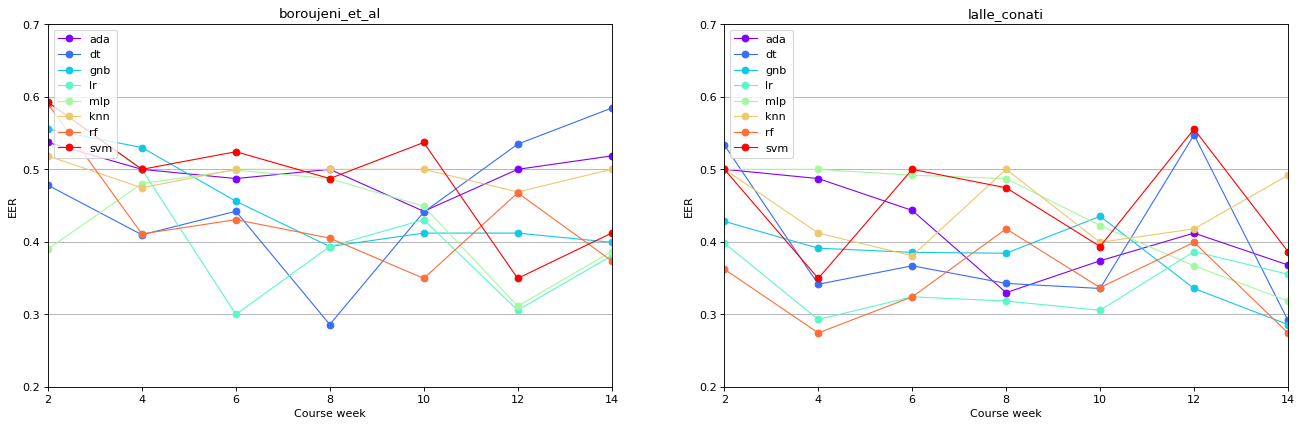

In [64]:
plot_metrics_along_weeks('EER')

In [68]:
events[events['EventType'] == 'Video.SeekBackward']

,AccountUserID,EventType,TimeStamp,VideoID,EventID,SeekType,OldTime,CurrentTime,NewTime,OldSpeed,...,Title,Source,Subchapter,Duration,ProblemID,ProblemType,MaximumSubmissions,Year,Date,Week
